In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
from moviepy.editor import VideoFileClip
import PIL
from math import factorial
from scipy.signal import argrelextrema
from scipy.interpolate import UnivariateSpline


In [3]:
def get_camera_calibration_points():
    """
    :return: A tuple of object points and image points to be used for image calibration
    """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    return objpoints, imgpoints


In [4]:
def get_camera_matrix(objpoints, imgpoints, image_shape):
    """
    Get matrix for calivrating camera
    :param objpoints:
    :param imgpoints:
    :param image_shape:
    :return:
    """
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape, None, None)
    return mtx, dist

In [5]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    Appy sobel transform
    :param gray:
    :param orient:
    :param sobel_kernel:
    :param thresh:
    :return:
    """
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [6]:
def change_perspective(image, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]))
    return warped


def get_warp_transform_matrix():
    src = np.float32([[425, 560], [865, 560], [1050, 680], [260, 680]])
    dst = np.float32([[515, 560], [765, 560], [765, 680], [515, 680]])
    return cv2.getPerspectiveTransform(src, dst)


def get_unwarp_transform_matrix():
    dst = np.float32([[425, 560], [865, 560], [1050, 680], [260, 680]])
    src = np.float32([[515, 560], [765, 560], [765, 680], [515, 680]])
    return cv2.getPerspectiveTransform(src, dst)

def warp_image(image):
    M = get_warp_transform_matrix()
    return cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]))


def unwarp_image(image):
    M = get_unwarp_transform_matrix()
    return cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]))

In [7]:
def get_binary_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:, :, 0]
    S = hls[:, :, 2]

    kernel_size = 31
    gradx_binary = abs_sobel_thresh(gray, 'x', sobel_kernel=kernel_size, thresh=(20, 100))
    grady_binary = abs_sobel_thresh(gray, 'y', sobel_kernel=kernel_size, thresh=(20, 100))

    s_binary = np.zeros_like(S)
    s_binary[(S > 150) & (S <= 255)] = 1
    h_binary = np.zeros_like(H)
    h_binary[(H > 10) & (H <= 50)] = 1

    sh_binary = np.zeros_like(H)
    sh_binary[((h_binary == 1) & (s_binary == 1))] = 1

    all_combined = np.zeros_like(gradx_binary)
    all_combined[((gradx_binary == 1) & (grady_binary == 1)) | (sh_binary == 1)] = 1
    return all_combined

In [8]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    """
    Smoothens a curnve

    Source - http://stackoverflow.com/questions/22988882/how-to-smooth-a-curve-in-python
    :param y:
    :param window_size:
    :param order:
    :param deriv:
    :param rate:
    :return:
    """
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order + 1)
    half_window = (window_size - 1) // 2
    # precompute coefficients
    b = np.mat([[k ** i for i in order_range] for k in range(-half_window, half_window + 1)])
    m = np.linalg.pinv(b).A[deriv] * rate ** deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs(y[1:half_window + 1][::-1] - y[0])
    lastvals = y[-1] + np.abs(y[-half_window - 1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve(m[::-1], y, mode='valid')

In [9]:
def get_lane_base(histogram):
    """
    :param histogram:
    :return: Probable x position of start of left and right lane at the bottom of the image
    """
    # Smoothen the histogram, doing it twice gives a really nice smooth curves
    smooth = savitzky_golay(histogram, 101, 1)
    smooth = savitzky_golay(smooth, 101, 1)

    midpoint = np.int(histogram.shape[0] / 2)
    # Get the local maxima in the left half of the histogram, corresponding to the left lane line
    left_maxima = argrelextrema(smooth[:midpoint], np.greater)
    # Get the local maxima in the right half of the histogram, corresponding to the right lane line
    right_maxima = argrelextrema(smooth[midpoint:], np.greater)

    # Return the maxima that's closest to the end of left half and the one to the beginning of right half
    return np.max(left_maxima), (np.min(right_maxima) + midpoint)


def get_parallelism_indx(image, left_fit, right_fit):
    """
    Calculates the standard deviation between the distance two points on curves with same y value
    This gives an indication about how parallel the two curves are
    :param image:
    :param left_fit:
    :param right_fit:
    :return:
    """
    ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    distance = right_fitx - left_fitx
    return np.std(distance)

def fit_lanes(binary_warped, histogram, old_fit, old_lane_distance):
    leftx_base, rightx_base = get_lane_base(histogram)
    lane_distance_in_pixels = rightx_base - leftx_base

    # If the lane distance is not in this range, we detected wrong lanes, so keep the old values
    if old_fit and (not (225 < lane_distance_in_pixels < 300)):
        return old_fit[0], old_fit[1], old_lane_distance

    nwindows = 10
    window_height = np.int(binary_warped.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 20
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
            nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
            nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If any of the arrays are empty, the lane detection has gone wrong, keep the old values
    if len(lefty) == 0 or len(leftx) == 0 or len(righty) == 0 or len(rightx) == 0:
        return old_fit[0], old_fit[1], old_lane_distance

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    if old_fit:
        parallelism_line_index = get_parallelism_indx(binary_warped, left_fit, right_fit)
        # If the distance between two curves varies a lot, that indicates that the curves are not parallel
        if parallelism_line_index > 20:
            return old_fit[0], old_fit[1], old_lane_distance

    return left_fit, right_fit, lane_distance_in_pixels

In [10]:
def draw_lane(ori_image, warped_image, left_fitx, right_fitx, ploty):
    """
    Draws lane onto the original image
    :param ori_image:
    :param warped_image:
    :param left_fitx:
    :param right_fitx:
    :param ploty:
    :return:
    """
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = unwarp_image(color_warp)

    # Combine the result with the original image
    return cv2.addWeighted(ori_image, 1, newwarp, 0.3, 0)

In [11]:
def undistort_image(image):
    global objpoints
    global imgpoints
    mtx, dist = get_camera_matrix(objpoints, imgpoints, image.shape[0:2])
    return cv2.undistort(image, mtx, dist, None, mtx)

In [12]:
def get_distance_from_center(image, left_fit, right_fit):
    m_per_pixel_x = 3.7 / 200  # meters per pixel in x dimension
    y = image.shape[0]
    left_x = left_fit[0] * y ** 2 + left_fit[1] * y + left_fit[2]
    right_x = right_fit[0] * y ** 2 + right_fit[1] * y + right_fit[2]
    lane_center = left_x + (right_x - left_x) / 2
    image_center = image.shape[1] / 2
    return (image_center - lane_center) * m_per_pixel_x


def get_curvature(ploty, leftx, rightx):
    m_per_pixel_x = 3.7 / 200  # meters per pixel in x dimension
    m_per_pixel_y = 3 / 95  # meters per pixel in x dimension
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty * m_per_pixel_y, leftx * m_per_pixel_x, 2)
    right_fit_cr = np.polyfit(ploty * m_per_pixel_y, rightx * m_per_pixel_x, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * m_per_pixel_y + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * m_per_pixel_y + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])
    return left_curverad, right_curverad

In [13]:
def process_image(image):
    global old_fit, frame, lane_distance
    frame += 1

    # if frame in [1124, ]:#395, 487, 548, 574, 575, 577, 588, 600, 602, 889, 913, 924, 942]:
    # PIL.Image.fromarray(image).save("./frame_{}.jpg".format(frame))
    # return image

    image = undistort_image(image)
    binary_warped = warp_image(get_binary_image(image))

    histogram = np.sum(binary_warped[binary_warped.shape[0] / 2:, :], axis=0)
    left_fit, right_fit, lane_distance = fit_lanes(binary_warped, histogram, old_fit, lane_distance)
    ploty = np.linspace(100, image.shape[0], image.shape[0] - 100)

    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]


    distance_from_center = get_distance_from_center(image, left_fit, right_fit)
    distance_from_center_str = "{0:.2f}m {1} of the center".format(abs(distance_from_center),
                                                                   "right" if distance_from_center > 0 else "left")

    left_curve, right_curve = get_curvature(ploty, left_fitx, right_fitx)

    if old_fit and ((max(left_curve, right_curve) / min(left_curve, right_curve)) > 2):
        left_fit = old_fit[0]
        right_fit = old_fit[1]
        left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
        left_curve, right_curve = get_curvature(ploty, left_fitx, right_fitx)

    old_fit = (left_fit, right_fit)

    image_with_lane = draw_lane(image, binary_warped, left_fitx, right_fitx, ploty)

    curvature_string = "L radius - {0:.2f}m, R radius - {1:.2f}m".format(left_curve, right_curve)
    cv2.putText(image_with_lane, curvature_string, (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0))
    cv2.putText(image_with_lane, "Distance from center - {}, Frame - {}".format(distance_from_center_str, frame),
                (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0))

    return image_with_lane

In [14]:
def process_project_video():
    challenge_output = './project_video_processed.mp4'
    clip2 = VideoFileClip('./project_video.mp4')
    challenge_clip = clip2.fl_image(process_image)
    challenge_clip.write_videofile(challenge_output, audio=False)

In [15]:
objpoints, imgpoints = get_camera_calibration_points()
old_fit = None

`get_camera_calibration_points` is used to generate the objectpoints and imagepoints to be used to calibrate the camera. If does this by finding chess corners in the calibration images provided in the camera_cal folder. 
`get_camera_matrix` then uses these values to generate the camera matric for undistoring the image. undistort_image then uses `cv2.undistort` to undistort the image using this camera matrix.
Below is the exmaple of undistorting the image 

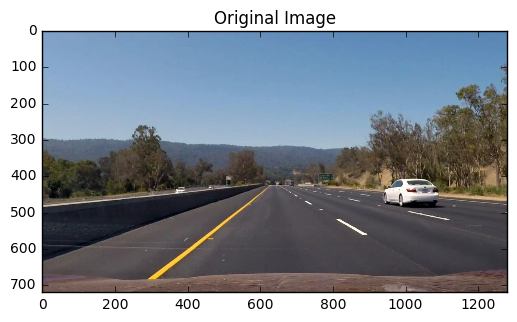

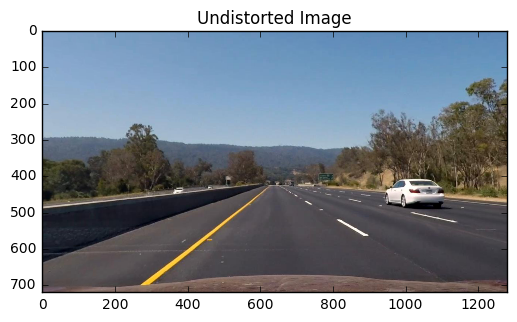

In [16]:
image = mpimg.imread('./frame_395.jpg')
plt.imshow(image)
plt.title("Original Image")
plt.show()
undistorted_image = undistort_image(image)
plt.imshow(undistorted_image)
plt.title("Undistorted Image")
plt.show()

`get_binary_image` has been defined to get the binary version of the image. It uses combination of H and S channel values and sobel gradient in both x and y direction to get a final binray image. Here's the outcome of `get_binary_image` when applied to the undistorted image

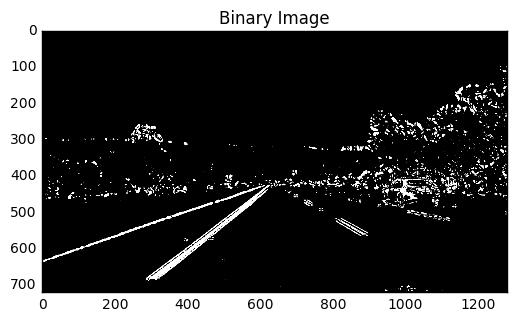

In [17]:
binary_image = get_binary_image(image)
plt.imshow(binary_image, cmap="gray")
plt.title("Binary Image")
plt.show()

`warp_image` has been defined to change the perspective of the image with follwoing values
```
src = np.float32([[425, 560], [865, 560], [1050, 680], [260, 680]])
dst = np.float32([[515, 560], [765, 560], [765, 680], [515, 680]])
```
`unwarp_image` the undo what `warp_image` did just by swapping the values of src and dst. Here's now it looks

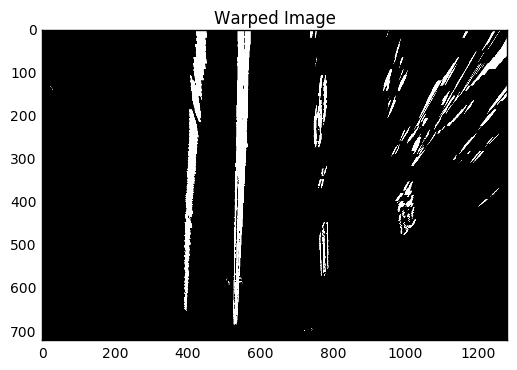

In [18]:
binary_warped = warp_image(binary_image)
plt.imshow(binary_warped, cmap="gray", aspect='auto')
plt.title("Warped Image")
plt.show()

In [19]:
old_lane_distance = 0
histogram = np.sum(binary_warped[binary_warped.shape[0] / 2:, :], axis=0)
left_fit, right_fit, old_lane_distance = fit_lanes(binary_warped, histogram, old_fit, old_lane_distance)

`fit_lanes` returns the curves representing left and right lines of the lane. It gets the histogram of number of ones at each x location. To find the peaks, I smoothened the histogram using http://stackoverflow.com/questions/22988882/how-to-smooth-a-curve-in-python. Using it twice made the curve really smooth. Then using `argrelextrema` I got the local maxima in the left half and right half of the image separately. Then picked up a one that's at the end of left half as the starting point for left line of the lane and one that's at the begining of the right half as starting point for the right line of the lane. `fit_lanes` ignores the detected lanes and uses the old ones if the curves are not parallel enough using standard deviation of distance between curve across curve. It also skips the lane detection if the base x positions of the line are too far apart indicating that we detected wrong lines. Trying to visualize this below.

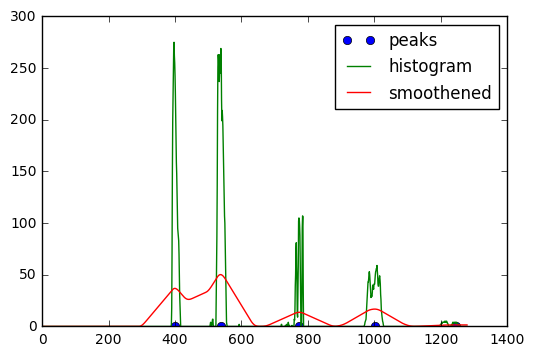

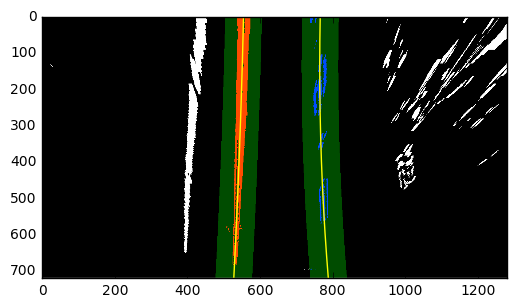

In [20]:
# Visualizing how lanes are getting detected in fit_lanes

x_values = list(range(histogram.shape[0]))
smooth = savitzky_golay(histogram, 101, 1) 
smooth = savitzky_golay(smooth, 101, 1)

midpoint = len(x_values) // 2
maxm = argrelextrema(smooth, np.greater)
left_maxima = argrelextrema(smooth[:midpoint], np.greater)
right_maxima = argrelextrema(smooth[midpoint:], np.greater)

plt.plot(maxm[0], np.zeros(len(maxm[0])), 'o', x_values, histogram, '-', x_values, smooth, '-')
plt.legend(['peaks', 'histogram', 'smoothened'], loc='best')
plt.show()


ploty = np.linspace(0, image.shape[0], image.shape[0])
left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 50
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

`draw_lane` then plots the lane and unwarps the image so that we get a result as follows.

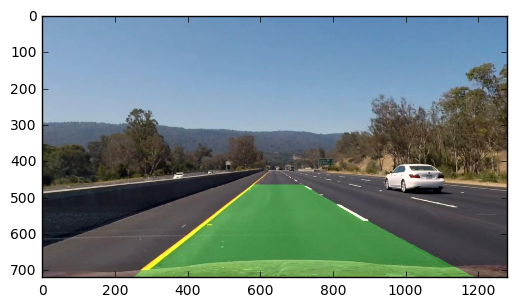

In [21]:
# Draw line back on the image
ploty = np.linspace(100, binary_warped.shape[0], binary_warped.shape[0] - 100)
left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
old_fit = (left_fit, right_fit)
image_with_lane = draw_lane(undistorted_image, binary_warped, left_fitx, right_fitx, ploty)
plt.imshow(image_with_lane)
plt.show()

Reflection:

The way perspective tranform was done in the tutorial gave just one lane in the warped image. I tried to modify it to get all the visible lane lines. With this approach, we can detect other lanes on the roads if needed. Also in tuturials, while getting the base x position for left and right lane, it was suggested to pick up the max value in the corresponding half of the image however, I tried to smoothen the histogram and used local maxima for the curve to get the base x. Other appoach could have been to get the gradient of the curve and use the value where the gradient curve crosses zero.

The defined pipeline works mostly well on the project video however I expect it to fail on roads with sharp turns where only one line of the lane is visible. Also it'll be difficult to detect the lanes in case the lighting conditions are not right (too dark or too bright). Will have to play around a little bit more with the way binary image is produced to get it working on the too much varing lighting conditions. Also will have to consider a case that there might be only one line of the lane visible if it's sharp turn and car is being driven on the edge of the cerve.